# Day 15 Analysis

Tyreek Hill receiving yards


Geno Smith has been the story of the 2022 NFL Season. A 10 year back-up who has led the Seahawks to a winning record and doing it with the best completion percentage in the league through the first 7 weeks. How does his completion percentage compare to not only the other QBs playing this season but also to previous seasons' first 7 weeks?

## Set Up

In [193]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Tyreek vs. The Field: 2022
First, let's look at how Tyreek's receiving yards ranks among other WRs this season.

In [194]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    week,
    receiving_yards AS rec_yds,
    receiving_tds AS rec_tds,
    receiving_air_yards AS rec_air_yds,
    ROUND(fantasy_points,2) AS pts,
    ROUND(fantasy_points_ppr,2) AS pts_ppr,
    COUNT() OVER(PARTITION BY player_id) AS games_played
FROM weekly 
WHERE season = 2022
    AND week <= 9
    AND position = 'WR'
    AND season_type = 'REG'
"""

df_2022 = pd.read_sql(query, conn)

In [195]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     1085 non-null   object 
 1   player_name   1085 non-null   object 
 2   week          1085 non-null   int64  
 3   rec_yds       1085 non-null   float64
 4   rec_tds       1085 non-null   int64  
 5   rec_air_yds   1085 non-null   float64
 6   pts           1085 non-null   float64
 7   pts_ppr       1085 non-null   float64
 8   games_played  1085 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 76.4+ KB


In [196]:
df_2022[['rec_yds', 'pts', 'pts_ppr', 'games_played']].describe()

,rec_yds,pts,pts_ppr,games_played
count,1085.000000,1085.000000,1085.000000,1085.000000
mean,38.312442,5.261401,8.301032,6.625806
std,37.129636,5.652937,7.772947,2.076507
min,-5.000000,-2.000000,-1.000000,1.000000
25%,8.000000,1.000000,2.100000,6.000000
50%,27.000000,3.300000,6.100000,7.000000
75%,59.000000,8.000000,12.600000,8.000000
max,190.000000,33.600000,44.800000,9.000000


Based on values for 25th and 75th percentiles, finding outliers using 1.5 * IQR will not be useful. Instead, I'll just take 50% of the mean as my lower value, or at least 15 passing attempts per game.

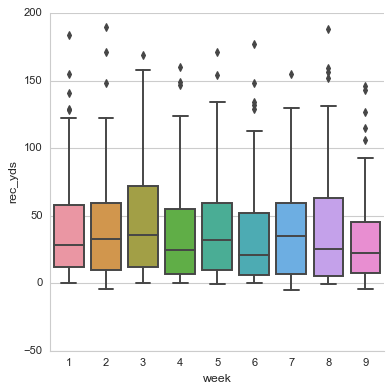

In [197]:
sns.catplot(
    x="week",
    y="rec_yds",
    data=df_2022,
    kind="box"
)

Interestingly enough, Week 3 seems to have the most "high performers" in terms of receiving yards since it has the highest mean (it's heavily right-skewed).

Looking at PPR points by week, Week 2 actually has a higher mean, but lower median than Week 3. We can say that Week 3 looks ot be the best in terms of yards and fantasy points so far.

In [198]:
df_2022.groupby('week')[['rec_yds', 'pts_ppr']].describe().round(3)

rec_yds                                                 pts_ppr         \
       count    mean     std  min    25%   50%    75%    max   count   mean   
week                                                                          
1      134.0  38.739  36.454  0.0  12.25  28.5  57.75  184.0   134.0  8.524   
2      128.0  40.539  38.486 -4.0   9.75  32.5  59.50  190.0   128.0  9.365   
3      123.0  44.073  38.414  0.0  12.00  36.0  72.00  169.0   123.0  9.074   
4      126.0  37.484  37.755  0.0   7.00  24.5  55.00  160.0   126.0  7.664   
5      127.0  39.079  36.801 -1.0   9.50  32.0  59.50  171.0   127.0  8.157   
6      113.0  34.611  36.603  0.0   6.00  21.0  52.00  177.0   113.0  7.920   
7      112.0  38.839  34.750 -5.0   6.75  35.0  59.50  155.0   112.0  8.360   
8      118.0  38.237  40.550 -1.0   5.25  25.5  63.00  188.0   118.0  8.292   
9      104.0  31.817  33.175 -4.0   7.75  22.0  45.00  146.0   104.0  7.099   

                                             
        std  min    25%   50%     75%   max  
week                                         
1     7.740 -0.7  2.775  6.50  12.475  39.4  
2     9.211 -1.0  2.600  7.10  13.000  44.8  
3     7.443 -0.2  2.850  7.30  14.400  30.9  
4     7.395  0.0  1.700  5.64  12.075  31.0  
5     7.289  0.0  2.100  6.50  12.000  32.1  
6     7.736 -0.5  1.800  4.80  12.800  32.2  
7     7.237  0.0  2.150  7.40  12.325  33.0  
8     8.246  0.0  1.600  6.15  12.660  39.6  
9     7.338  0.0  1.800  4.35  10.375  36.6

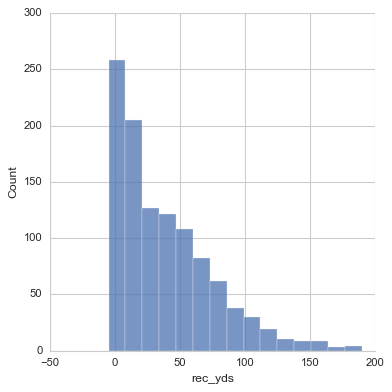

In [199]:
sns.displot(
    x="rec_yds",
    data=df_2022,
    kind="hist",
    bins=15
)

The distribution for receiving yards is heavily right-skewed, with the majority of performances around 25-35 yards. This is actually somewhat surprising! Is this typical for previous seasons?

In [200]:
# Tyreek Hill's games
tyreek_2022 = df_2022[df_2022['player_name'] == 'Tyreek Hill'][['player_name', 'week', 'rec_yds', 'rec_tds', 'rec_air_yds', 'pts', 'pts_ppr']]

tyreek_tot_yds = tyreek_2022['rec_yds'].sum()
tyreek_yds_per_game = round(tyreek_tot_yds/len(tyreek_2022),2)

tyreek_2022

,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr
221,Tyreek Hill,1,94.0,0,109.0,10.0,18.0
222,Tyreek Hill,2,190.0,2,138.0,31.0,42.0
223,Tyreek Hill,3,33.0,0,34.0,3.3,5.3
224,Tyreek Hill,4,160.0,0,172.0,15.9,25.9
225,Tyreek Hill,5,47.0,0,32.0,6.0,13.0
226,Tyreek Hill,6,177.0,0,181.0,17.7,29.7
227,Tyreek Hill,7,72.0,0,171.0,7.2,14.2
228,Tyreek Hill,8,188.0,0,222.0,19.5,31.5
229,Tyreek Hill,9,143.0,1,112.0,20.3,27.3


In [201]:
print(f"Total receiving yards for 2022: {tyreek_tot_yds}")
print(f"Rec yds per game for 2022: {tyreek_yds_per_game}")

print(f"On pace for {tyreek_yds_per_game * 17} receiving yards for 2022")

Total receiving yards for 2022: 1104.0
Rec yds per game for 2022: 122.67
On pace for 2085.39 receiving yards for 2022


So tyreek Hill has totalled 1,104 yards in 9 games for an average of 122.67 yards per game. He is on pace to total more than 2,000 receiving yards this season, a feat that hasn't been done since...?

Has it been done?

In [202]:
# Get best WR season (by receiving yards)
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        SUM(receiving_yards) AS tot_rec_yds,
        SUM(receiving_tds) AS tot_rec_tds,
        SUM(receiving_air_yards) AS tot_rec_air_yds,
        ROUND(SUM(fantasy_points),2) AS pts,
        ROUND(SUM(fantasy_points_ppr),2) AS pts_ppr,
        COUNT(*) AS games_played
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
    GROUP BY player_id, player_name, season
)
SELECT
    player_name,
    season,
    tot_rec_yds,
    tot_rec_tds,
    (tot_rec_yds / games_played) AS yds_per_gm,
    (1.0 * tot_rec_tds / games_played) AS tds_per_gm,
    (tot_rec_air_yds / games_played) AS air_yds_per_gm,
    (pts / games_played) AS pts_per_gm,
    (pts_ppr / games_played) AS pts_ppr_per_gm,
    games_played
FROM data
WHERE tot_rec_yds >= (
    SELECT MAX(tot_rec_yds)
    FROM data
)
"""

top_wr = pd.read_sql(query, conn)

In [203]:
top_wr

,player_name,season,tot_rec_yds,tot_rec_tds,yds_per_gm,tds_per_gm,air_yds_per_gm,pts_per_gm,pts_ppr_per_gm,games_played
0,Calvin Johnson,2012,1964.0,5,122.75,0.3125,172.0625,13.775,21.4,16


In [204]:
tyreek_2022.groupby('player_name').mean().round(2).drop('week', axis=1)

,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr
player_name,,,,,
Tyreek Hill,122.67,0.33,130.11,14.54,22.99


Actually, a season with 2,000 yards actually hasn't been accomplished (at least from 1999-2022 which is the extent of my data). Calvin Johnson (aka Megatron) had the most single season yards at 1,1964 with an average of 122.75 yds/game. Comparing key stats:

| Stat (per Game)   | Tyreek | Megatron |
| ----------------- | ------ | -------- |
| Yards             | 122.67 | 122.75   |
| Touchdowns        | 0.33   | 0.3125   |
| Air Yards         | 130.11 | 172.06   |
| Points (Standard) | 14.54  | 13.775   |
| Points (PPR)      | 22.99  | 21.4     | 

Extremely similar raw yards and TDs per game. However, Tyreek is performing as well on **32% less** air yards per game. Tyreek is known as an extremely speedy player so my hunch is that he is getting a lot of his yards after the catch. Something to explore in the future.

In conclusion, Tyreek is having a historically good season in terms of receiving yards. He is keeping up with Megatron's incredible 2012 season where he had the most receiving yards of any Wide Receiver in NFL history. However, we can't ignore the fact that **there are 17 games in the 2022 season** vs. 16 games in the 2012 season when Megatron set the record. Based on his per game average, Megatron would have totalled over 2,000 receiving yards!

I'll continue to monitor Tyreek's season and see how he matches up on various stats on a *per game basis*. Given that this season is 1 more game than usual, it makes sense to focus on per game averages to compare players. 

## Top WRs in 2022
I want to find out which wide receivers have the most consistent production so I'll look at how many weeks they ended up in the top 5 in terms of receiving yards and fantasy points (PPR). Then I'll see how Tyreek Hill compares to these players.

In [205]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        week,
        receiving_yards AS rec_yds,
        receiving_tds AS rec_tds,
        receiving_air_yards AS rec_air_yds,
        ROUND(fantasy_points,2) AS pts,
        ROUND(fantasy_points_ppr,2) AS pts_ppr,
        COUNT() OVER(PARTITION BY player_id) AS num_games,
        RANK() OVER(PARTITION BY week ORDER BY receiving_yards DESC) AS r_rec_yds,
        RANK() OVER(PARTITION BY week ORDER BY fantasy_points_ppr DESC) AS r_pts_ppr
    FROM weekly 
    WHERE season = 2022
        AND week <= 9
        -- AND position = 'WR'
        AND season_type = 'REG'
)
SELECT *
FROM data
ORDER BY week, r_rec_yds ASC
"""

df_2022 = pd.read_sql(query, conn)

print(df_2022.shape)
df_2022.head()

(2690, 11)


,player_id,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
0,00-0036322,Justin Jefferson,1,184.0,2,118.0,30.4,39.4,8,1,1
1,00-0035676,A.J. Brown,1,155.0,0,94.0,15.5,25.5,8,2,14
2,00-0031381,Davante Adams,1,141.0,1,177.0,20.1,30.1,8,3,6
3,00-0036900,Ja'Marr Chase,1,129.0,1,108.0,18.9,28.9,7,4,7
4,00-0033908,Cooper Kupp,1,128.0,1,116.0,18.8,31.8,8,5,4


In [206]:
df_top5_by_week = df_2022[df_2022['r_rec_yds'] <= 5]

In [207]:
df_top5_by_week['player_name'].value_counts()[:15]

Tyreek Hill                 5
Justin Jefferson            4
Davante Adams               3
Ja'Marr Chase               3
Cooper Kupp                 3
Jaylen Waddle               2
Stefon Diggs                2
A.J. Brown                  2
Chris Olave                 2
Marquez Valdes-Scantling    1
Tyler Boyd                  1
JuJu Smith-Schuster         1
Amari Cooper                1
DeAndre Hopkins             1
D.J. Moore                  1
Name: player_name, dtype: int64

So we have 9 players (including Tyreek) who have at least two appearances in the top 5 rankings for receiving yards. Let's get 2 other players so we can compare Tyreek and the next best 10 guys. Let's see the stats of these players with only 1 top 5 appearance

In [208]:
filter = df_top5_by_week['player_name'].value_counts() == 1

players_one_top5 = df_top5_by_week['player_name'].value_counts()[filter].index

df_top5_by_week[df_top5_by_week['player_name'].isin(players_one_top5)]


,player_id,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
320,00-0034348,Courtland Sutton,2,122.0,0,133.0,12.70,19.70,8,4,28
321,00-0036963,Amon-Ra St. Brown,2,116.0,2,86.0,30.40,39.40,7,5,5
635,00-0036912,DeVonta Smith,3,169.0,1,205.0,22.90,30.90,8,1,2
636,00-0033555,Mack Hollins,3,158.0,1,137.0,21.96,29.96,8,2,4
637,00-0031547,DeVante Parker,3,156.0,0,212.0,15.60,20.60,7,3,24
639,00-0035662,Marquise Brown,3,140.0,0,140.0,14.00,28.00,6,5,6
944,00-0035229,T.J. Hockenson,4,179.0,2,111.0,31.90,39.90,8,1,1
946,00-0035640,DK Metcalf,4,149.0,0,159.0,14.90,21.90,9,3,27
948,00-0036410,Tee Higgins,4,124.0,1,96.0,18.40,25.40,8,5,16
1255,00-0036196,Gabe Davis,5,171.0,2,159.0,29.10,32.10,7,1,6


Let's get the season averages for these players

In [209]:
season_one_top5 = df_2022[df_2022['player_name'].isin(players_one_top5)]\
                    .groupby('player_name')[['rec_yds', 'num_games', 'r_pts_ppr']]\
                    .mean()\
                    .sort_values(['rec_yds'], ascending=False)\
                    .reset_index()\
                    .round(2)
season_one_top5.head()

,player_name,rec_yds,num_games,r_pts_ppr
0,DeAndre Hopkins,99.33,3.0,27.67
1,Travis Kelce,82.38,8.0,33.38
2,Marquise Brown,80.83,6.0,49.17
3,JuJu Smith-Schuster,72.75,8.0,86.38
4,Mike Williams,70.71,7.0,90.57


Even though Hopkins has only 3 games played, I expect his average to stay around this mark since he is the WR1 in the Arizona offense. Funny to see Travis Kelce (a Tight End!) pop up but not totally surprising since Kansas City uses him like a WR.

With these two players added, we can now compare Tyreek Hill's receiving yards to his top 10 "peers" in the stat. How does he rank week to week?

In [210]:
top_10_peers = list(df_top5_by_week['player_name'].value_counts()[df_top5_by_week['player_name'].value_counts() != 1].index)
top_10_peers.pop(0) # remove Tyreek

# Add Hopkins and Kelce
for player in list(season_one_top5['player_name'])[:2]:
    top_10_peers.append(player)

# Validate
print(len(top_10_peers))
top_10_peers

10


['Justin Jefferson',
 'Davante Adams',
 "Ja'Marr Chase",
 'Cooper Kupp',
 'Jaylen Waddle',
 'Stefon Diggs',
 'A.J. Brown',
 'Chris Olave',
 'DeAndre Hopkins',
 'Travis Kelce']

In [211]:
top_10_peers_by_week = df_2022[df_2022['player_name'].isin(top_10_peers)]\
                    .groupby('week')\
                    .mean()\
                    .reset_index()\
                    .round(3)
top_10_peers_by_week

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_43321/336647178.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()\


,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
0,1,121.111,0.889,99.667,17.756,26.089,8.000,13.667,25.556
1,2,82.333,0.889,129.778,13.167,20.056,8.000,42.111,68.556
2,3,65.444,0.444,96.667,10.144,15.367,8.000,57.556,68.222
3,4,89.556,0.222,93.889,11.033,17.811,8.000,23.111,58.667
4,5,76.556,1.000,75.222,14.024,20.024,8.000,50.000,61.111
5,6,110.143,0.571,76.857,14.457,21.457,8.000,10.143,26.143
6,7,103.333,0.333,100.000,12.333,19.500,7.167,8.000,35.667
7,8,95.125,1.000,108.625,15.625,22.125,7.500,37.750,59.875
8,9,93.111,0.778,113.778,14.100,20.656,7.556,14.333,30.000


In [212]:
df_2022[df_2022['player_name'] == 'Tyreek Hill']

,player_id,player_name,week,rec_yds,rec_tds,rec_air_yds,pts,pts_ppr,num_games,r_rec_yds,r_pts_ppr
12,00-0033040,Tyreek Hill,1,94.0,0,109.0,10.0,18.0,9,13,43
317,00-0033040,Tyreek Hill,2,190.0,2,138.0,31.0,42.0,9,1,3
724,00-0033040,Tyreek Hill,3,33.0,0,34.0,3.3,5.3,9,89,181
945,00-0033040,Tyreek Hill,4,160.0,0,172.0,15.9,25.9,9,2,13
1314,00-0033040,Tyreek Hill,5,47.0,0,32.0,6.0,13.0,9,60,74
1573,00-0033040,Tyreek Hill,6,177.0,0,181.0,17.7,29.7,9,1,4
1872,00-0033040,Tyreek Hill,7,72.0,0,171.0,7.2,14.2,9,23,62
2126,00-0033040,Tyreek Hill,8,188.0,0,222.0,19.5,31.5,9,1,8
2422,00-0033040,Tyreek Hill,9,143.0,1,112.0,20.3,27.3,9,2,6


It's feast or famine for Tyreek until the last two weeks. He's either out of the top 10 or 1 or 2.

In [213]:
top_3_perf = df_2022[df_2022['r_rec_yds'] <= 3]

top_5_wr = top_3_perf.groupby('player_name')\
    .agg({'player_id':'count', 'num_games':'mean'})\
    .sort_values('player_id', ascending=False)\
    .reset_index()

top_5_wr.rename(columns={'player_id':'top_3_finishes'}, inplace=True)

top_5_wr['pct_of_gms_played'] = round(top_5_wr['top_3_finishes'] / top_5_wr['num_games'],2)

top_5_wr = top_5_wr.head()
top_5_wr

,player_name,top_3_finishes,num_games,pct_of_gms_played
0,Tyreek Hill,5,9.0,0.56
1,Justin Jefferson,2,8.0,0.25
2,Stefon Diggs,2,8.0,0.25
3,A.J. Brown,2,8.0,0.25
4,Davante Adams,2,8.0,0.25


Tyreek has been in the top 3 over half of his games! The next highest is at 40%.

In [214]:
top_3_perf['player_name'].value_counts().head().index

Index(['Tyreek Hill', 'Justin Jefferson', 'Davante Adams', 'Stefon Diggs',
       'A.J. Brown'],
      dtype='object')

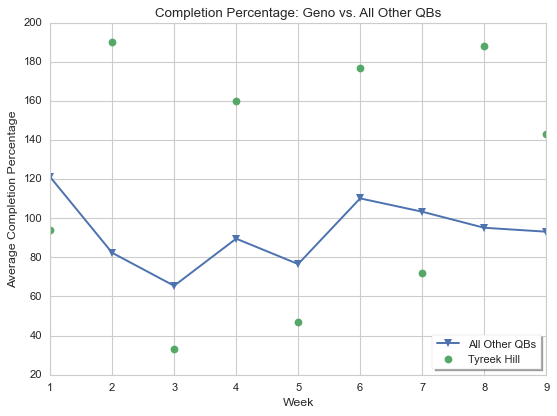

In [219]:
# plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(
    'week', 
    'rec_yds', 
    data=top_10_peers_by_week,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'rec_yds', 
    data=df_2022[df_2022['player_name'] == 'Tyreek Hill'],
    marker='o',
    linestyle ='',
    label='Tyreek Hill')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Percentage: Geno vs. All Other QBs')

plt.legend(frameon = 1, facecolor='white', framealpha=1, loc="lower right", shadow=True)
# plt.grid(x,y)
# plt.ylim(60,85)
# plt.xlim(0, 9)

plt.show()

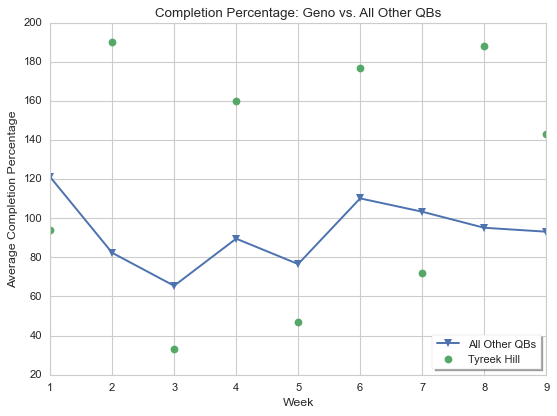

In [220]:
# plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(
    'week', 
    'rec_yds', 
    data=top_10_peers_by_week,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'rec_yds', 
    data=df_2022[df_2022['player_name'] == 'Tyreek Hill'],
    marker='o',
    linestyle ='',
    label='Tyreek Hill')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Percentage: Geno vs. All Other QBs')

plt.legend(frameon = 1, facecolor='white', framealpha=1, loc="lower right", shadow=True)
# plt.grid(x,y)
# plt.ylim(60,85)
# plt.xlim(0, 9)

plt.show()

In [216]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [217]:
f_tyreek = (df_2022['player_name'] == 'Tyreek Hill')

df_tyreek = df_2022[f_tyreek]
df_all_others = 

SyntaxError: invalid syntax (393214353.py, line 4)

In [ ]:
# Get best WR season (by receiving yards)
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        SUM(receiving_yards) AS rec_yds,
        SUM(receiving_tds) AS rec_tds,
        SUM(receiving_air_yards) AS tot_rec_air_yds,
        ROUND(SUM(fantasy_points),2) AS pts,
        ROUND(SUM(fantasy_points_ppr),2) AS pts_ppr,
        COUNT(*) AS games_played
    FROM weekly 
    WHERE season = 2022
        AND position = 'WR'
        AND season_type = 'REG'
    -- GROUP BY player_id, player_name, season
)
SELECT
    player_name,
    season,
    tot_rec_yds,
    tot_rec_tds,
    (tot_rec_yds / games_played) AS yds_per_gm,
    (1.0 * tot_rec_tds / games_played) AS tds_per_gm,
    (tot_rec_air_yds / games_played) AS air_yds_per_gm,
    (pts / games_played) AS pts_per_gm,
    (pts_ppr / games_played) AS pts_ppr_per_gm,
    games_played
FROM data
WHERE tot_rec_yds >= (
    SELECT MAX(tot_rec_yds)
    FROM data
)
"""

top_wr = pd.read_sql(query, conn)

In [ ]:
# Aggregate by week to find the average completion percentage per week
# Make sure to leave out Geno Smith to get the true average of his peers
by_week = df_2022_clean[df_2022_clean['player_name'] != 'Geno Smith'] \
    .groupby('week') \
    .mean() \
    .reset_index()

by_player_week = df_2022_clean \
    .groupby(['week', 'player_name']) \
    .mean() \
    .reset_index()

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_39813/2864774432.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean() \
/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_39813/2864774432.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean() \


In [ ]:
by_week

,week,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
0,1,22.354839,35.129032,63.452258,245.225806,1.580645,0.870968,259.161290,16.692903,5.516129
1,2,22.400000,34.833333,64.327667,242.833333,1.800000,0.833333,264.400000,17.910000,5.766667
2,3,22.516129,35.645161,63.221935,251.870968,1.193548,0.677419,290.032258,15.597419,5.774194
3,4,20.310345,31.931034,62.921724,230.310345,1.379310,0.793103,243.413793,15.381379,5.896552
4,5,21.709677,33.741935,64.595161,239.096774,0.935484,0.645161,254.677419,14.625161,5.774194
5,6,21.307692,33.538462,63.316154,218.961538,1.307692,0.615385,233.038462,14.712308,5.692308
6,7,22.500000,33.538462,67.344615,246.076923,1.192308,0.730769,245.769231,15.300769,5.269231


In [ ]:
by_player_week[by_player_week['player_name'] == 'Tyreek Hill']

,week,player_name,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
7,1,Geno Smith,23.0,28.0,82.14,195.0,2.0,0.0,144.0,17.20,7.0
39,2,Geno Smith,24.0,30.0,80.00,197.0,0.0,1.0,162.0,6.08,7.0
70,3,Geno Smith,32.0,44.0,72.73,325.0,2.0,1.0,412.0,18.90,7.0
103,4,Geno Smith,23.0,30.0,76.67,320.0,2.0,0.0,320.0,31.70,7.0
134,5,Geno Smith,16.0,25.0,64.00,268.0,3.0,0.0,294.0,24.02,7.0
163,6,Geno Smith,20.0,31.0,64.52,197.0,0.0,0.0,213.0,12.68,7.0
192,7,Geno Smith,20.0,27.0,74.07,210.0,2.0,1.0,206.0,13.10,7.0


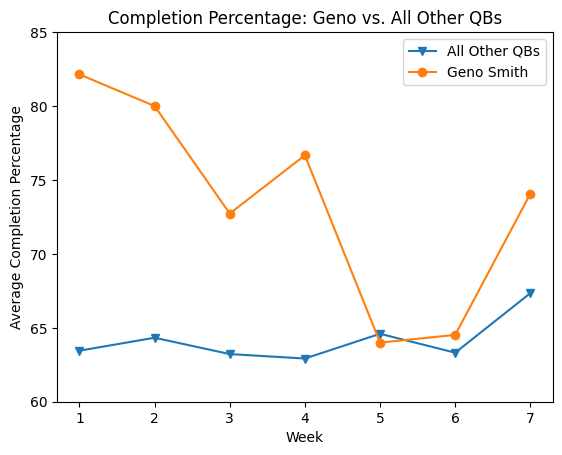

In [ ]:
plt.plot(
    'week', 
    'comp_pct', 
    data=by_week,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'comp_pct', 
    data=by_player_week[by_player_week['player_name'] == 'Geno Smith'],
    marker='o',
    label='Geno Smith')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Percentage: Geno vs. All Other QBs')

plt.legend(loc="upper right")
plt.ylim(60,85)

plt.show()

Geno started out hot, reverted to the mean weeks 5-6 and rebounded Week 7. Overall, he is having quite a season, doing quite a bit better than the league average. in terms of completion percentage.

In [ ]:
# Get the top 5 QBs by average completion percentage
df_2022_clean.groupby('player_name')[['comp_pct','games_played']] \
    .mean() \
    .sort_values('comp_pct', ascending=False)[:5]

,comp_pct,games_played
player_name,,
Geno Smith,73.447143,7.0
Matthew Stafford,71.643333,6.0
Bailey Zappe,70.462500,4.0
Joe Burrow,68.934286,7.0
Daniel Jones,68.531667,6.0


Geno does indeed have the highest average completion percentage among NFL QBs this season. Controlling for games played, he's beating Joe Burrow by ~4.5%, who has also started every game.

## Geno vs. The Field: 1999-2022
Below is a recreation of the above analysis using data from [nflverse](https://nflverse.nflverse.com) going back to 1999. Is Geno Smith having a historic season?

In [ ]:
# Get data for all seasons

query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played
FROM weekly 
WHERE week < 8
    AND position = 'QB'
    AND season_type = 'REG'
    AND attempts >= 15
"""

df_all = pd.read_sql(query, conn)

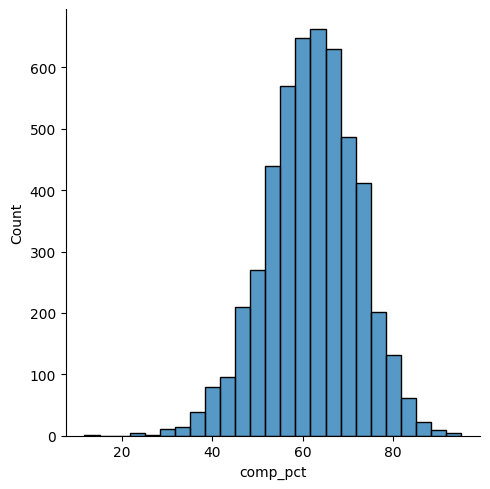

In [ ]:
# Check distribution

sns.displot(
    x="comp_pct",
    data=df_all,
    kind="hist",
    bins=25
)

In [ ]:
df_all[['comp_pct','attempts','completions']].describe()

,comp_pct,attempts,completions
count,5002.000000,5002.000000,5002.000000
mean,62.028910,32.958816,20.472811
std,10.025591,8.746097,6.306077
min,11.760000,15.000000,2.000000
25%,55.560000,27.000000,16.000000
50%,62.260000,33.000000,20.000000
75%,68.750000,39.000000,24.000000
max,95.000000,68.000000,45.000000


In [ ]:
# Filter out Geno's data for this season
geno_2022 = (df_all['player_name'] == 'Geno Smith') & (df_all['season'] == 2022)

by_week_all = df_all[~geno_2022].groupby('week').mean().reset_index()

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_39813/3040588277.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_week_all = df_all[~geno_2022].groupby('week').mean().reset_index()


In [ ]:
by_week_all

,week,season,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
0,1,2010.608753,20.716180,33.221485,62.360809,234.737401,1.432361,0.874005,193.974801,14.660451,73.938992
1,2,2010.498695,20.502611,32.950392,62.039948,235.569191,1.417755,0.887728,199.633159,14.917154,74.003916
2,3,2010.858311,20.828338,33.254768,62.713665,238.121253,1.400545,0.874659,206.929155,15.002643,69.209809
3,4,2010.747518,20.601418,33.092199,62.080043,236.953191,1.439716,0.870922,198.165957,14.878411,71.380142
4,5,2010.679767,20.497817,33.062591,61.865138,235.512373,1.420670,0.917031,194.508006,14.811325,72.921397
5,6,2010.572917,20.363095,33.093750,61.547917,235.291667,1.386905,0.970238,200.007440,14.584435,72.340774
6,7,2010.406204,19.710487,32.000000,61.376691,225.087149,1.361891,0.861152,189.886263,14.164786,74.521418


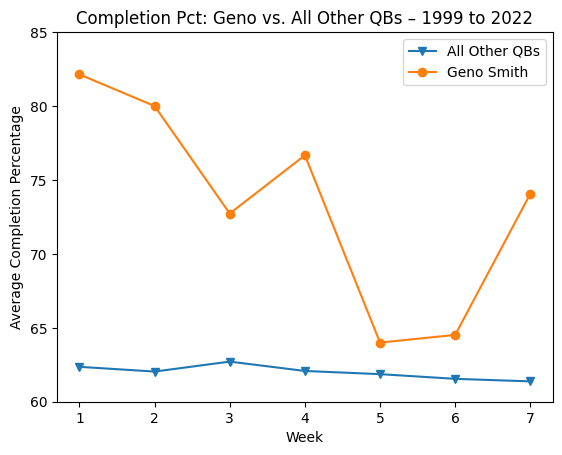

In [ ]:
plt.plot(
    'week', 
    'comp_pct', 
    data=by_week_all,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'comp_pct', 
    data=by_player_week[by_player_week['player_name'] == 'Geno Smith'],
    marker='o',
    label='Geno Smith')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Pct: Geno vs. All Other QBs – 1999 to 2022')

plt.legend(loc="upper right")
plt.ylim(60,85)

plt.show()

### Ranking Geno's 2022 Season

In [ ]:
# Get data for all seasons

query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 15
)
SELECT
    player_name,
    season,
    week,
    attempts,
    completions,
    comp_pct,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played,
    fantasy_pts,
    RANK() OVER(PARTITION BY week ORDER BY comp_pct DESC) AS r_comp_pct_by_week
FROM data
"""

df_best = pd.read_sql(query, conn)

In [ ]:
best_per_week = df_best[df_best['r_comp_pct_by_week'] == 1]
best_per_week

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
1770,Drew Brees,2018,5,29,26,89.66,6,26.72,1
1929,Gardner Minshew,2020,1,20,19,95.00,7,20.82,1
3019,Kurt Warner,2009,2,26,24,92.31,6,17.62,1
4252,Ryan Fitzpatrick,2020,3,20,18,90.00,6,24.20,1
4285,Ryan Tannehill,2015,7,19,18,94.74,6,27.58,1
4462,Steve McNair,2003,4,16,15,93.75,7,18.94,1
4890,Trevor Lawrence,2022,6,22,20,90.91,7,24.90,1


In [ ]:
df_best[(df_best['player_name'] == 'Geno Smith') & (df_best['season'] == 2022)]

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
1952,Geno Smith,2022,1,28,23,82.14,7,17.20,13
1953,Geno Smith,2022,2,30,24,80.00,7,6.08,25
1954,Geno Smith,2022,3,44,32,72.73,7,18.90,103
1955,Geno Smith,2022,4,30,23,76.67,7,31.70,51
1956,Geno Smith,2022,5,25,16,64.00,7,24.02,291
1957,Geno Smith,2022,6,31,20,64.52,7,12.68,256
1958,Geno Smith,2022,7,27,20,74.07,7,13.10,76


For all the talk, none of Geno's weekly performances in the 2022 even crack the top 10 in terms of completion percentages. However, if we compare the number of attempts by Geno Smith vs. the top performers, we see a big discrepancy – the best performers only threw 20-25 times! Geno throws around 25-30 times. 

Increasing the attempts threshold from 15 to 25 and re-running the rankings will make for a better comparison.

In [ ]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
)
SELECT
    player_name,
    season,
    week,
    attempts,
    completions,
    comp_pct,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played,
    fantasy_pts,
    RANK() OVER(PARTITION BY week ORDER BY comp_pct DESC) AS r_comp_pct_by_week
FROM data
"""

df_best_GTE_25_att = pd.read_sql(query, conn)

df_best_GTE_25_att[(df_best_GTE_25_att['player_name'] == 'Geno Smith') & (df_best_GTE_25_att['season'] == 2022)]

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
1632,Geno Smith,2022,1,28,23,82.14,7,17.20,10
1633,Geno Smith,2022,2,30,24,80.00,7,6.08,23
1634,Geno Smith,2022,3,44,32,72.73,7,18.90,82
1635,Geno Smith,2022,4,30,23,76.67,7,31.70,39
1636,Geno Smith,2022,5,25,16,64.00,7,24.02,241
1637,Geno Smith,2022,6,31,20,64.52,7,12.68,212
1638,Geno Smith,2022,7,27,20,74.07,7,13.10,60


A little better but not remarkable. His Week 1 performance was top 10 but that's really the only thing that was remarkable. To add insult to injury that performance only netted a middling 17.20 fantasy points.

Last chance, let's rank his average through the first 7 weeks vs. every QB's average through the first 7 weeks. Will keep the attempts threshold at 25 per game.

In [ ]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
), aggregations AS (
    SELECT
       player_name,
       season,
       ROUND(AVG(comp_pct), 2) AS avg_comp_pct,
       ROUND(AVG(attempts), 2) AS avg_attempts,
       COUNT(*) AS num_games,
       SUM(fantasy_pts) AS tot_fantasy_pts
    FROM data
    GROUP BY player_name, season
), rankings AS (
    SELECT
        player_name,
        season,
        avg_comp_pct,
        avg_attempts,
        tot_fantasy_pts,
        num_games,
        ROW_NUMBER() OVER(ORDER BY avg_comp_pct DESC) AS r_avg_comp_pct,
        ROW_NUMBER() OVER(ORDER BY tot_fantasy_pts DESC) AS r_fantasy_pts
    FROM aggregations
)
SELECT *
FROM rankings
WHERE num_games = 7
"""

pd.read_sql(query, conn).head(10)

,player_name,season,avg_comp_pct,avg_attempts,tot_fantasy_pts,num_games,r_avg_comp_pct,r_fantasy_pts
0,Tom Brady,2007,75.13,32.71,186.10,7,11,4
1,Geno Smith,2022,73.45,30.71,123.68,7,19,95
2,Kyler Murray,2021,73.23,31.86,168.68,7,23,12
3,Peyton Manning,2013,72.47,41.29,194.30,7,27,1
4,Teddy Bridgewater,2020,72.06,33.43,118.30,7,33,122
5,Matt Ryan,2018,71.88,37.57,170.10,7,37,10
6,Drew Brees,2011,71.51,42.71,162.58,7,43,18
7,Dak Prescott,2019,71.43,34.00,153.22,7,44,27
8,Aaron Rodgers,2011,71.32,34.14,188.38,7,46,3
9,Matt Ryan,2019,71.15,40.71,141.20,7,48,47


When controlling for players who have played every game through Week 7, and looking at **only percentage completion**, Geno is actually having a historically good start to the season! The top 10 list includes some of the best to ever play QB such as Tom Brady, Peyton Manning, Drew Brees, and Aaron Rodgers.

However, good percentage completion does not equal fantasy football production! Looking at the top 5, Geno has more in common with Teddy Bridgewater than Peyton Manning in terms of fantasy football scoring potential. Teddy was also a backup for many years.

It will be interesting to revisit this towards the end of the season to see if Geno can keep it up (and maybe start producing some significant fantasy points for those who have decided to start him due to the hype).